# Kalman Tracking Demos

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

import simulator
from environment import RectangularEnvironment
from targets import PointTarget
from vis import TrackingVis
from sensors import OmniSensor, DirectionalSensor
from pubsub import Broker, Subscriber, Publisher
from tracker import KalmanTracker, RealTimeKalmanTracker
from scheduler import SimpleScheduler
from performance import TrackingStats
import time
from IPython.display import display
import torch

%matplotlib notebook

# Track one object using best 2 of 4 sensors 

In [237]:
broker=Broker()

#Define the environment
env     = RectangularEnvironment(-10,10,-10,10)

#Create a target to track
target1 = PointTarget(id="Target1",broker=broker,dt=0.1)

#Create sensors
sensor_latency = 0
sensor_std_scale = 0.01
sensor0 = OmniSensor(np.array([-10,10]),id="S0",std_scale=sensor_std_scale,color="c",broker=broker,dt=0.1,latency=sensor_latency)
sensor1 = OmniSensor(np.array([10,10]),id="S1",std_scale=sensor_std_scale,color="m",broker=broker,dt=0.1,latency=sensor_latency)
sensor2 = OmniSensor(np.array([10,-10]),id="S2",std_scale=sensor_std_scale,color="g",broker=broker,dt=0.1,latency=sensor_latency)
sensor3 = OmniSensor(np.array([-10,-10]),id="S3",std_scale=sensor_std_scale,color="k",broker=broker,dt=0.1,latency=sensor_latency)

#Create the simulator and add objects
sim     = simulator.Simulator("Simple Tracking",env,[])

sim.add_object(target1)
sim.add_object(sensor0)
sim.add_object(sensor1)
sim.add_object(sensor2)
sim.add_object(sensor3)

# Generate a data set

In [238]:
T=100
sensors = [sensor0,sensor1,sensor2,sensor3]
D = len(sensors)
z_pos = []
z_cov = []
x     = torch.zeros(2,T)
for t in range(T):
    target1.step()
    x[:,t] = torch.FloatTensor(target1.x[:2]).flatten()
    
    obs_pos = torch.zeros(2,D)
    obs_cov = []
    for d,sensor in enumerate(sensors):
        sensor.step(wait=False)
        obs_pos[:,d] = torch.FloatTensor(sensor.det_pos).flatten()
        obs_cov.append(sensor.det_cov)
        
    z_pos.append(obs_pos)
    z_cov.append(obs_cov)
        
    
  

Loss tensor([[9325.4004]], grad_fn=<DivBackward0>)


<IPython.core.display.Javascript object>


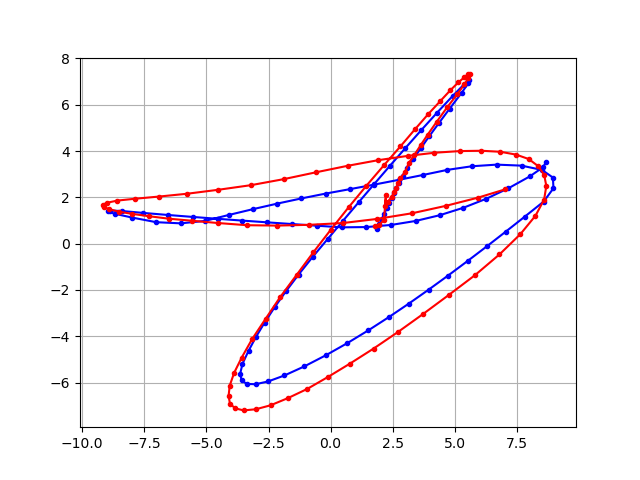

In [260]:
from tracker import TorchMultiObsKalmanFilter
tmokf = TorchMultiObsKalmanFilter(0.1,0.1)

#Plot track using default parameters
x_pos_hat, x_cov_hat = tmokf.forward(z_pos,z_cov)
print("Loss",tmokf.loss(x,x_pos_hat,x_cov_hat))

plt.figure()
plt.plot(x[0,:],x[1,:],".b-")
plt.plot(x_pos_hat[0,:].detach().numpy(),x_pos_hat[1,:].detach().numpy(),".r-")
plt.grid(True)

In [261]:
#Learn the model
tmokf.fit(x,z_pos,z_cov, max_iter=100, lr=5)

Iteration: 0: Loss: 9325.4004  std_acc: 2.8099
Iteration: 10: Loss: -2.9199  std_acc: 19.3341
Iteration: 20: Loss: -2.8914  std_acc: 24.3237
Iteration: 30: Loss: -2.8812  std_acc: 26.2490
Iteration: 40: Loss: -2.8774  std_acc: 27.0062
Iteration: 50: Loss: -2.8759  std_acc: 27.3010
Iteration: 60: Loss: -2.8754  std_acc: 27.4140
Iteration: 70: Loss: -2.8752  std_acc: 27.4567
Iteration: 80: Loss: -2.8751  std_acc: 27.4726
Iteration: 90: Loss: -2.8751  std_acc: 27.4784


Loss tensor([[-2.8751]], grad_fn=<DivBackward0>)


<IPython.core.display.Javascript object>


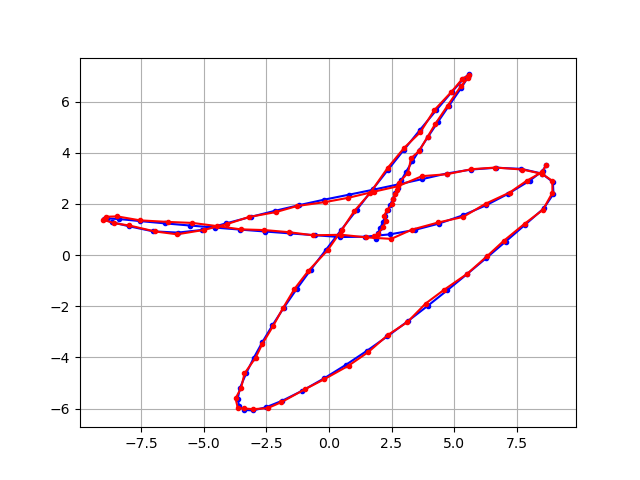

In [262]:
#Plot track using default parameters
x_pos_hat, x_cov_hat = tmokf.forward(z_pos,z_cov)
print("Loss",tmokf.loss(x,x_pos_hat,x_cov_hat))

plt.figure()
plt.plot(x[0,:],x[1,:],".b-")
plt.plot(x_pos_hat[0,:].detach().numpy(),x_pos_hat[1,:].detach().numpy(),".r-")
plt.grid(True)